# Part 3. Machine Learning


## Import libraries

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import warnings
import numpy as np
from numpy import array
warnings.filterwarnings('ignore')

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from pandas.plotting import autocorrelation_plot

In [3]:
np.random.seed(42)

## Data loading

In [4]:
bit_data=pd.read_csv('bit_data.csv',header=0, parse_dates=[0])

In [6]:
bit_data['Date'] = pd.to_datetime(bit_data['Date'])
bit_data.set_index('Date', inplace=True)

In [7]:
bit_data.head()

,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,Return,Change,Volatility,MA7,MA21,Momentum,MACD,Signal,Upper_band,Lower_band
Date,,,,,,,,,,,,,,,,,,
2013-05-19 23:59:59,Bitcoin,BTC,124.500000,119.570999,123.210999,121.989998,0.0,1.363205e+09,-0.010,-1.508003,8.471155,118.709001,117.159143,115.760002,-3.645462,-5.658709,137.200466,97.117819
2013-05-20 23:59:59,Bitcoin,BTC,123.621002,120.120003,122.500000,122.000000,0.0,1.363710e+09,-0.004,0.010002,8.256357,119.283286,116.085810,120.014999,-3.142245,-5.155416,131.946473,100.225146
2013-05-21 23:59:59,Bitcoin,BTC,123.000000,121.209999,122.019997,122.879997,0.0,1.374013e+09,0.007,0.879997,8.080808,120.909000,115.318190,120.498001,-2.641979,-4.652728,127.699871,102.936510
2013-05-22 23:59:59,Bitcoin,BTC,124.000999,122.000000,122.889999,123.889000,0.0,1.385779e+09,0.008,1.009003,7.948854,122.290285,115.646714,118.989998,-2.139434,-4.150069,128.569000,102.724428
2013-05-23 23:59:59,Bitcoin,BTC,126.933998,123.099998,123.800003,126.699997,0.0,1.417770e+09,0.023,2.810997,7.969404,123.424570,116.670048,119.000000,-1.497082,-3.619472,129.524510,103.815585


## 1. ARIMA


AutoRegressive Integrated Moving Average (ARIMA) is a model that captures a suite of different standard temporal structures in time series data.

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

We will split train and test data to evaluate performance of ARIMA model.

In [14]:
print('Bitcoin historical data contains {} entries'.format(bit_data.shape[0]))
bit_data[['Return']].head()

Bitcoin historical data contains 2842 entries


,Return
Date,
2013-05-19 23:59:59,-0.010
2013-05-20 23:59:59,-0.004
2013-05-21 23:59:59,0.007
2013-05-22 23:59:59,0.008
2013-05-23 23:59:59,0.023


## Autocorrelation

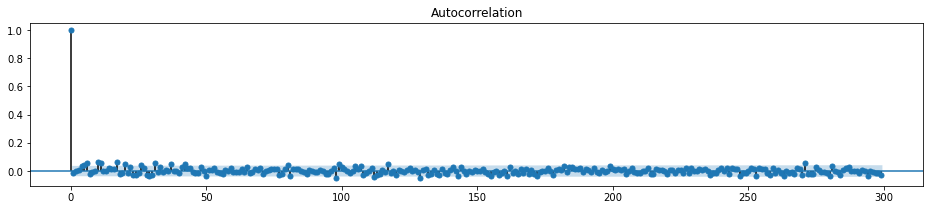

In [17]:
plt.rcParams['figure.figsize'] = (16, 3)
plot_acf(bit_data.Return, lags=range(300))
plt.show()

Let's take a look at the Autocorrelation Function. The graph shows how time series data points correlate between each other. We should ignore first value in the graph that shows perfect correlation (value = 1), because it tells how data point is correlated to itself. What's important in this graph is how first data point is correlated to second, third and so on. We can see that it's so weak, it's close to zero. What does it mean to our analysis? It means that ARIMA is pretty much useless here, because it uses previous data points to predict following.

To make a conclusion we're going to try different orders and see how well they perform on a given data

In [21]:
# ARIMA orders
orders = [(0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0)]

# Splitting into train and test sets
train = list(bit_data['Return'][1000:1900].values)
test = list(bit_data['Return'][1900:2800].values)

all_predictions = {}

for order in orders:
    
    try:
        # History will contain original train set, 
        # but with each iteration we will add one datapoint
        # from the test set as we continue prediction
        history = train.copy()
        order_predictions = []
        
        for i in range(len(test)):
            
            model = ARIMA(history, order=order) # defining ARIMA model
            model_fit = model.fit(disp=0) # fitting model
            y_hat = model_fit.forecast() # predicting 'return'
            order_predictions.append(y_hat[0][0]) # first element ([0][0]) is a prediction
            history.append(test[i]) # simply adding following day 'return' value to the model    
            print('Prediction: {} of {}'.format(i+1,len(test)), end='\r')
        
        accuracy = accuracy_score( 
            functions.binary(test), 
            functions.binary(order_predictions) 
        )        
        print('                             ', end='\r')
        print('{} - {:.1f}% accuracy'.format(order, round(accuracy, 3)*100), end='\n')
        all_predictions[order] = order_predictions
    
    except:
        print(order, '<== Wrong Order', end='\n')
        pass

(0, 0, 0) <== Wrong Order
(1, 0, 0) <== Wrong Order
(0, 1, 0) <== Wrong Order
(0, 0, 1) <== Wrong Order
(1, 1, 0) <== Wrong Order
